# Вопросы и задания

Визуализируйте показатели частоты дыхания, полученные с обоих девайсов.
Что нужно сделать для калибровки обоих сигналов по времени?
Сделайте вывод о связи сигналов во время различных активностей. Какие причины могут привести к несоответствию сигналов? Можно ли восстановить один поток из другого?



In [217]:
#! pip install biosppy
#pip install --upgrade mglearn
#!pip install --upgrade scikit-learn==0.20.3

In [489]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from opensignalsreader import OpenSignalsReader
# Handle table-like data and matrices
import numpy as np
import pandas as pd
from biosppy import storage
from biosppy.signals import ecg
from biosppy.signals import resp
from scipy import stats
import biosppy as bs

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from plotly import graph_objects as go
import numpy.fft as fft
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import bspline


Файл respiration_data.txt содержит данные газоанализатора в табличном формате с расширенным заголовком. Нас интересует показатель частоты дыхания (ЧД, она же RR - respiration rate).

In [219]:
df = pd.read_fwf('respiration_data_table.txt', header=None, index=False)
df.to_csv('respiration_data_table.csv')
df.columns = df.iloc[2]
df = df[4:]
#biosppy не считывает str
# pd.to_numeric(df['ЧД'],errors='coerce')
listt = []
for i in df['ЧД']:
     listt.append(float(i))
df['ЧД'] = listt

заполним недостающие секунды

In [220]:
df['Время'].to_timestamp
df['Время'] = pd.to_timedelta(df['Время'])
idx = pd.timedelta_range(0, '00:17:53', freq='S', name='time')
df = df.set_index('Время').reindex(idx).reset_index()

In [221]:
df

2,time,VT (BTPS),ЧД,V'E (BTPS),V'max,(BTPS),FEetO2,FEetCO2,PetO2,PetCO2,...,Вт,EE,EE/кг,CHO,ЖИР,EFF,BR,V'O2/kg_Lean,EE/kg_Lean,BR
0,0 days 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0 days 00:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0 days 00:00:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0 days 00:00:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0 days 00:00:04,0.69,20.5,14.1,0.65,NaN,13.97,5.89,95.4,40.2,...,0,3354,46,28,0,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,0 days 00:17:49,2,21.1,39.5,2.54,NaN,16.27,5.77,111.2,39.4,...,56,7946,108,67,0,NaN,0,0,0,0
1070,0 days 00:17:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1071,0 days 00:17:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1072,0 days 00:17:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


чтобы вычислить "плавающие средние" по секундам, приведем наш фрейм к листу, а затем к словарю, также уберем отсутствующие значения

In [222]:
resp_rate = df[['ЧД']].values.tolist()
resp_rate = [x.pop() for x in resp_rate]
rates = []
for rate in resp_rate:
    if str(rate)=='nan':
        rate = 'find_rate'
        rates.append(rate)
    else:
        rates.append(rate)
#каждый индекс будет ключом
rate_dict = {}
for key, value in enumerate(rates):
    rate_dict[key]=value
    

заполним недостающие посекундные значения "плавающими средними" по соседним непустым значениям, которые изначально предоставлялись нам в столбце "ЧД"

In [223]:
prev_rate = 0
record_idx = 0

for idx, rate in rate_dict.items():
    
    if rate=='find_rate' and idx!=0:
             
        if rate_dict[idx-1]!='find_rate' and rate_dict[idx+1]=='find_rate':
            record_idx = idx
            prev_rate = float(rate_dict[idx-1])
            
        elif rate_dict[idx-1]=='find_rate' and rate_dict[idx+1]!='find_rate':
            rate = (prev_rate + float(rate_dict[idx+1]))/2
            rate = round(rate, 1)
            rate_dict[idx] = float(rate)
            for i in range(record_idx, idx+1):
                if rate_dict[i]=='find_rate':
                    rate_dict[i]=float(rate)
    
for idx, rate in rate_dict.items():
    
    if rate=='find_rate':
        rate_dict[idx] = rate_dict[idx-1]

в примере частота дыхания выше - домножим все показатели на коэффициент для наглядности

In [224]:
for key, value in rate_dict.items():
    value*=100
    rate_dict[key] = value

приведем дополненные данные по ЧД в требуемый формат для biosppy

In [225]:
rate_respiration_head  = pd.DataFrame([rate_dict]).T
rate_respiration_head.to_csv('resp_rate_head.txt', index=False, sep=' ', header=None)

посмотрим, открывается ли график частоты дыхания с девайса, который крепится к голове:

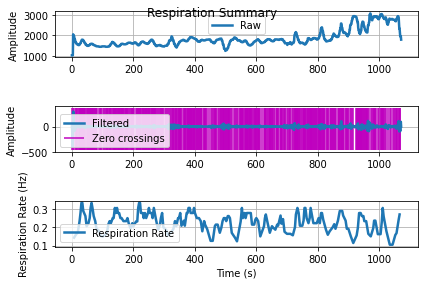

In [239]:
signal, mdata = storage.load_txt('resp_rate_head.txt')
out_head = resp.resp(signal=signal, sampling_rate=1., show=True)  

Займемся "грудным" девайсом. Визуализируем его данные с помощью Opensignalreader, затем приведем к удобоваримому для biosppy виду

In [227]:
acq = OpenSignalsReader('bitalino_data.txt', show=False, raw=True)

согласно заданию, первый канал соответствует показателям активности мышц грудной клетки, второй - ЭКГ - нам нужен первый
визуализируем

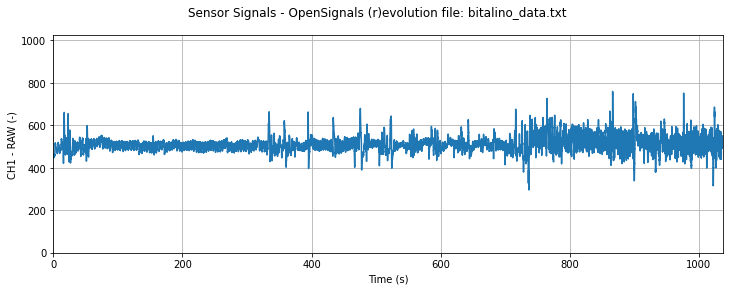

In [228]:
acq.plot(1)

In [229]:
resp_rate_breast = acq.raw()['RAW']
resp_rate_breast = pd.DataFrame(resp_rate_breast)
resp_rate_breast.columns = resp_rate_breast.columns+1
resp_rate_breast.index = resp_rate_breast.index + 1

In [230]:
resp_rate_breast.to_csv('resp_rate_breast.txt', index=False, sep=' ', header=None)

посмотрим на график частоты дыхания с девайса, который крепится к груди и сравним его с графиком первого девайса, а также посмотрим на корреляцию данных между показателями девайсов

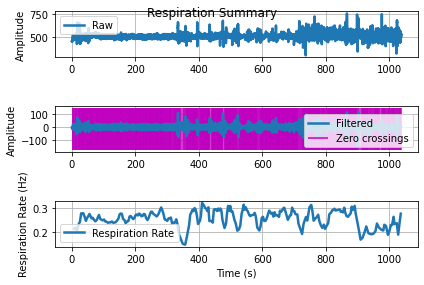

In [455]:
signal, mdata = storage.load_txt('resp_rate_breast.txt')
out_breast = resp.resp(signal=signal, sampling_rate=1000., show=True)  

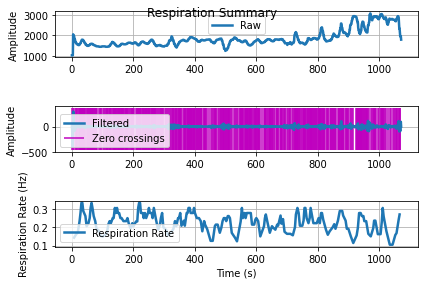

In [240]:
out_head = resp.resp(signal=signal, sampling_rate=1., show=True)  

в данный момент графики могут сильно различаться, потому что один девайс считывает с головы, другой - с мышц груди и показания получаются разными. Чтобы получить примерно одинаковые условия, домножим и показания "грудного" девайса на общий средний коэффициент
Также необходимо учесть, что если частота дыхания у нас измерялась посекундно (и даже не каждую секунду) в течение примерно 15 минут, и при этом оба девайса работали на одинаковых условиях, грудной девайс имеет показатели в миллисекунду - нужно привести показатели времени "грудного" девайса к посекундным - оставить только около 1000 значений

In [469]:
breast = pd.read_fwf('resp_rate_breast.txt', header=None, index=False)
breast.to_csv('resp_rate_breast.csv')
head = pd.read_fwf('resp_rate_head.txt', header=None, index=False)
head.to_csv('resp_rate_head.csv')

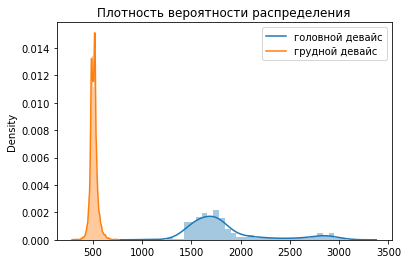

In [470]:
sns.distplot(head.iloc[:])
sns.distplot(breast.iloc[:])
plt.title('Плотность вероятности распределения')
plt.legend(['головной девайс', 'грудной девайс'])
plt.show()

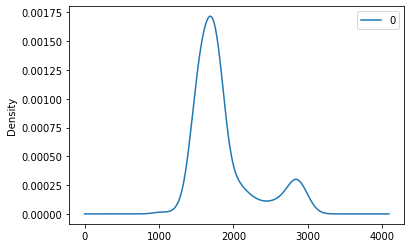

In [474]:
head.plot.kde()

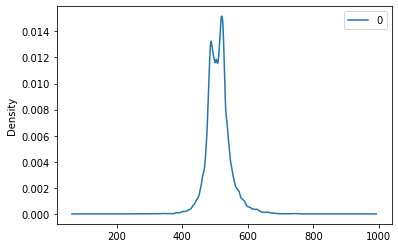

In [475]:
breast.plot.kde()

In [471]:
Y1_agg = breast.mean(axis=1)
Y2_agg = head.mean(axis=1)
stats.ttest_ind(Y1_agg, Y2_agg)

Ttest_indResult(statistic=-1139.7666750108697, pvalue=0.0)

Значения p-value говорит нам  том, что группы похожи между собой, но судя по графикам, показатели головного девайса имеют скорее биноминальное, чем нормальное распределение,  - поэтому судить о схожести не совсем верно

Посмотрим, как изменятся наши показатели, если привести данные по грудному девайсу в более похожий на данные первого девайса вид с помощью домножений на коэффициенты и приведения к секундам

In [476]:
breast_rate = breast[0].values.tolist()
breast_dict = {}
breast_list = []
breast_dict2 = {}
for key, value in enumerate(breast_rate):
    breast_dict[key]=value
    if key%1000 == 0:
        key /=1000
        breast_list.append(value)

In [477]:
breast= pd.DataFrame([breast_list]).T
#приведем к общему с помощью домножения на коэффициент
breast = breast*(head.mean()/breast.mean())
breast.to_csv('resp_rate_breast2.txt', index=False, sep=' ', header=None)

In [478]:
print(f'судя по показаниям, грудной девайс работал {round(breast.shape[0]/1000/60,1)} мин,\
      головной девайс работал {head.shape[0]/60} мин')

судя по показаниям, грудной девайс работал 0.0 мин,      головной девайс работал 17.9 мин


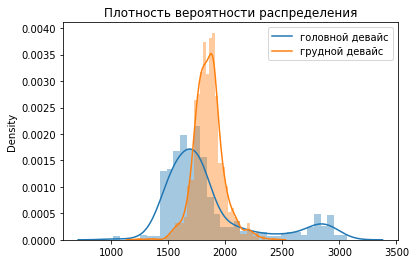

In [479]:
sns.distplot(head.iloc[:])
sns.distplot(breast.iloc[:])
plt.title('Плотность вероятности распределения')
plt.legend(['головной девайс', 'грудной девайс'])
plt.show()

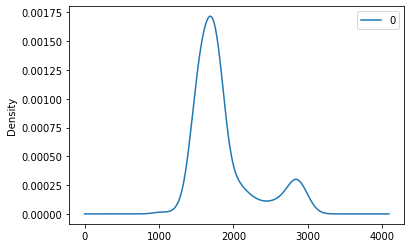

In [480]:
head.plot.kde()

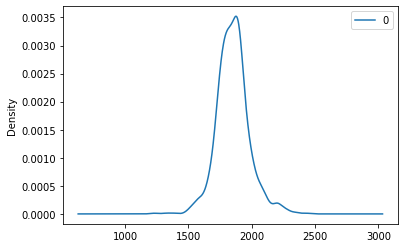

In [482]:
breast.plot.kde()

In [483]:
Y1_agg = breast.mean(axis=1)
Y2_agg = head.mean(axis=1)
stats.ttest_ind(Y1_agg, Y2_agg)

Ttest_indResult(statistic=0.0, pvalue=1.0)

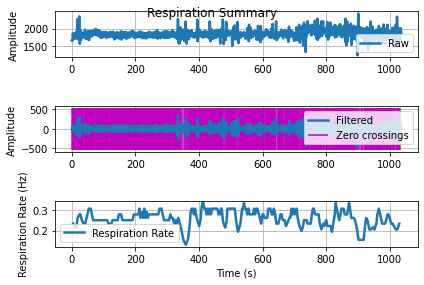

In [494]:
signal, mdata = storage.load_txt('resp_rate_breast2.txt')
out_breast = resp.resp(signal=signal, sampling_rate=1., show=True)  


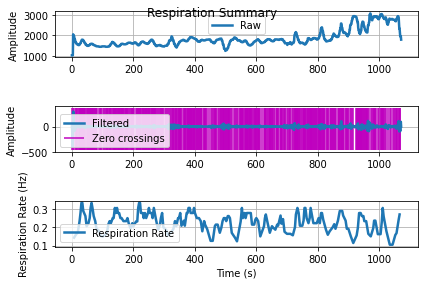

In [453]:
signal, mdata = storage.load_txt('resp_rate_head.txt')
out_head = resp.resp(signal=signal, sampling_rate=1., show=True)  
    

амплитуда цикла входа-выдоха с головного девайса указывает на то, что под конец человеку требовалось больше кислорода 

Судить о схожести графиков теперь также сложно. Более-менее информационным графиком является график с показателями мнгновенной частоты дыхания(Hz) - по нему видно, что по колебаниям мышц груди можно примерно понять, когда заканчивалась и начиналась каждая физическая активность и что вторая была сложнее первой (или человек устал),  то время, как головной девайс указывает на то, что частота примерно одинакова, но в сменах активности можно скорее додумать, чем явно наблюдать зависимости. Один поток из другого по всей видимости восстановить нельзя